In [153]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [154]:
%store -r df_cleaned

In [155]:
df_cleaned

,week,wPreis,Plz,full,date
date,,,,,
2020-09-14,2020-37,-37.519318,"['25', '24']",A2 - geschreddert,2020-09-14
2020-09-14,2020-37,-37.519318,"['25', '24']",A1 & A2 - geschreddert,2020-09-14
2020-09-14,2020-37,-23.445068,"['80', '81', '82', '83', '84', '85', '93', '94']",A3 - geschreddert,2020-09-14
2020-09-14,2020-37,-36.379163,"['70', '71', '73', '74', '75', '76']",A2 & A3 - geschreddert,2020-09-14
2020-09-14,2020-37,-27.983877,"['25', '24']",A2 & A3 - geschreddert,2020-09-14
...,...,...,...,...,...
2024-04-22,2024-17,7.216049,"['50', '51', '52', '53']",A2 & A3 - geschreddert,2024-04-22
2024-04-22,2024-17,33.349057,"['70', '71', '73', '74', '75', '76']",A2 & A3 - geschreddert,2024-04-22
2024-04-22,2024-17,2.409250,"['25', '24']",A2 - geschreddert,2024-04-22


In [156]:
df = df_cleaned # pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [157]:
# df['date']= pd.to_datetime(df['date'])
# df.index = df['date']
# df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [158]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [159]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']

In [160]:
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [161]:
datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]

# Modelling - Train, test split

In [162]:
len(TS1_A1A2)

187

In [163]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

## ARIMA Model


### Static forecast using ARIMA


No retraining. We just use the best ARIMA model to forecast for the test set and evaluate.
We use the once-trained best ARIMA model to forecast for the 6 "steps" in one go. 

In [164]:
model = ARIMA(df_train['wPreis'], order=(4, 1, 0))
static_ARIMA = model.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [165]:
static_ARIMA.forecast(steps=nobs) 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


181    9.286463
182    9.123604
183    7.039256
184    6.442182
185    7.395429
186    7.041302
Name: predicted_mean, dtype: float64

The ARIMA forecast function does not require an "input" other than the steps, so either
- we can do a static forecast (train once on the entire training dataset) and test the predictions for the required steps to compare with the test dataset or
- train in a walk-forward validation where we retrain the model with every step of the test dataset on the new training set which includes the new observation

In [166]:
fc = static_ARIMA.forecast(steps=nobs) 
a = np.array(fc)
df_forecast = pd.DataFrame(a, index=df_test.index[-nobs:], columns=['Predicted_wPreis'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


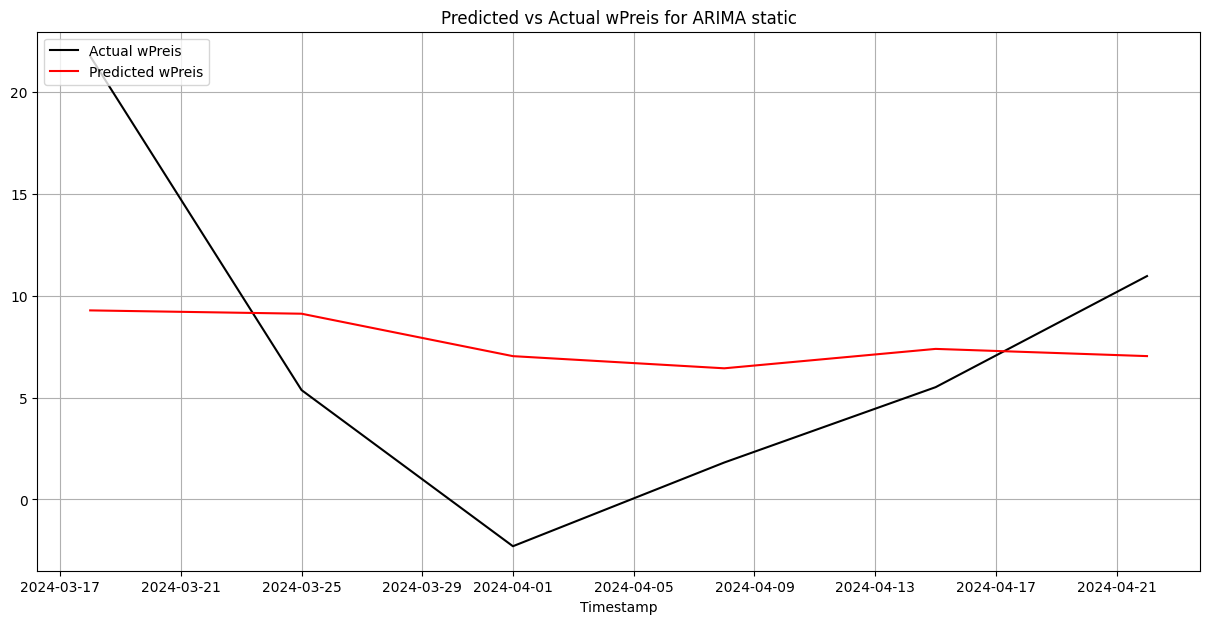

In [167]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(df_test["wPreis"], color='black', label='Actual wPreis')
plt.plot(df_forecast, color='red', label='Predicted wPreis')
plt.xlabel("Timestamp")
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Predicted vs Actual wPreis for ARIMA static')
plt.show()

We will define a forecast accuracyy function that will calculate the mean error, RMSE and also the direction accuracy. 

In [168]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast)
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae':mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [169]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('ARIMA static forecast Accuracy of: wPreis')
stat_accuracy_prod = forecast_accuracy(df_forecast['Predicted_wPreis'].values, df_test['wPreis'])
for k, v in stat_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

ARIMA static forecast Accuracy of: wPreis
mae    :  6.0017
me     :  0.5297
rmse   :  7.0418
direction_accuracy :  0.6


# Walk forward validation using ARIMA model

Training the whole model at each iteration including the new observation (for the next day)  

In [170]:
X = df_train["wPreis"].values

Take 148 observations for training and 6 for testing.

In [171]:
train, test = df_train["wPreis"].values, df_test["wPreis"].values

In [172]:
train

array([-37.51931788, -28.69009585, -29.68807862, -25.6304334 ,
       -29.07379398, -24.93642602, -35.26209517, -28.06563229,
       -28.47266599, -28.21685813, -29.18520815, -32.36064526,
       -20.27214677, -18.80845203, -23.58340467, -35.43666563,
       -23.06625847, -22.99784234, -31.41962306, -25.46027349,
       -23.68194297, -21.47771259, -27.02904785, -24.82276444,
       -23.25520954, -25.32197924, -22.30413021, -23.38024324,
       -25.17015002, -20.85821571, -23.60348981, -24.86044273,
       -23.64540855, -25.72826243, -20.17778383, -26.36851112,
       -21.90534062, -23.64226891, -25.04513087, -24.65590187,
       -21.77319638, -24.9461431 , -23.90837982, -25.23754357,
       -19.73324755, -24.54094226, -24.73818078, -22.97021231,
       -19.21154856, -16.66741517, -26.54786465, -22.45099313,
       -22.93310518, -23.38212367, -23.28028169, -26.65816299,
       -22.07703349, -17.78619097, -18.98931101,  -7.41127285,
        -6.21131882,  -1.98035287,   1.61215148,   0.48

In [173]:
history = [x for x in df_train['wPreis'].values] # "list comprehensions". 
expect=[]

In [174]:
predictions = list()
for t in range(len(test)): # 6 times reiterate
    model = ARIMA(history, order=(4,1,0))  
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = df_test['wPreis'][t]
    history.append(obs) # appends the real observation at each loop! 
    expect.append(obs)

    
# print(expect)
# print(predictions)

In [175]:
df_wPreis = pd.DataFrame(
    {'observations': expect,
     'forecast': predictions, 
    })


In [176]:
def adjust(val, length= 10): return str(val).ljust(length) # 10
print('Walk-forward Validation Forecast Accuracy of wPreis')
wf_accuracy_prod = forecast_accuracy(df_wPreis['forecast'].values, df_wPreis['observations'].values)
for k, v in wf_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Walk-forward Validation Forecast Accuracy of wPreis
mae        :  8.0967
me         :  -0.6224
rmse       :  9.4342
direction_accuracy :  0.4


Here, the me and rmse has improved but the direction_accuracy has decreased even further!

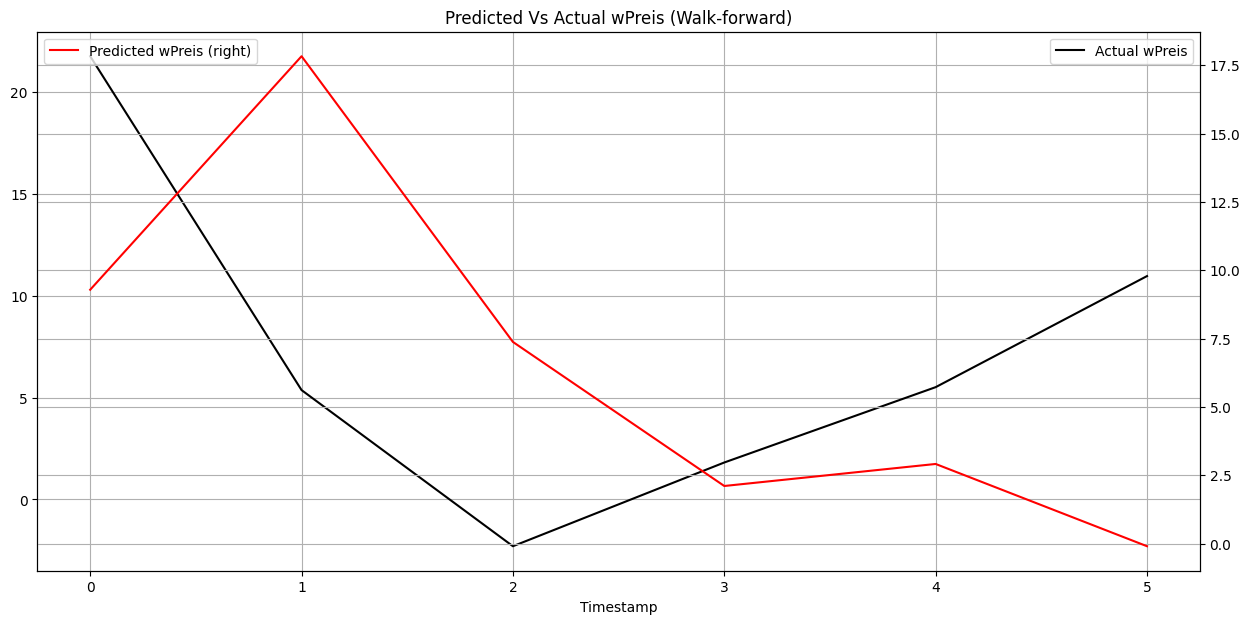

In [177]:
plt.figure(figsize= (15,7))
plt.xlabel("Timestamp")

ax1 = df_wPreis.observations.plot(color = 'black', grid = True, label = 'Actual wPreis')
ax2 = df_wPreis.forecast.plot(color = 'red', grid = True, secondary_y = True, label = 'Predicted wPreis')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Predicted Vs Actual wPreis (Walk-forward)')
plt.show()

In [178]:
ARIMA_static = pd.DataFrame([stat_accuracy_prod])
ARIMA_walk_forward = pd.DataFrame([wf_accuracy_prod])

In [179]:
ARIMA_static

,mae,me,rmse,direction_accuracy
0,6.001718,0.529747,7.041768,0.6


In [180]:
%store ARIMA_static
%store ARIMA_walk_forward


Stored 'ARIMA_static' (DataFrame)
Stored 'ARIMA_walk_forward' (DataFrame)


## All other clusters and categories

In [191]:
# For each dataset data
def static_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]

    # Static forecast
    model = ARIMA(df_train['wPreis'], order=(4, 1, 0))
    static_ARIMA = model.fit()
    static_ARIMA.forecast(steps=nobs) 
    fc = static_ARIMA.forecast(steps=nobs) 
    a = np.array(fc)
    df_forecast = pd.DataFrame(a, index=df_test.index[-nobs:], columns=['Predicted_wPreis'])

    def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast)
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae':mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}

    def adjust(val, length= 6): return str(val).ljust(length) # length
    print(f'ARIMA static forecast Accuracy of: wPreis in {cluster} for {category}')
    stat_accuracy_prod = forecast_accuracy(df_forecast['Predicted_wPreis'].values, df_test['wPreis'])
    for k, v in stat_accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))




In [192]:
def wf_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]
    
    history = [x for x in df_train['wPreis'].values] # "list comprehensions". 
    expect=[]

    predictions = list()
    for t in range(len(test)): # 6 times reiterate
        model = ARIMA(history, order=(4,1,0))  
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = df_test['wPreis'][t]
        history.append(obs) # appends the real observation at each loop! 
        expect.append(obs)

    df_wPreis = pd.DataFrame(
    {'observations': expect,
     'forecast': predictions, 
    })

    def adjust(val, length= 10): return str(val).ljust(length) # 10
    print(f'Walk-forward Validation Forecast Accuracy of wPreis in {cluster} for {category}')
    wf_accuracy_prod = forecast_accuracy(df_wPreis['forecast'].values, df_wPreis['observations'].values)
    for k, v in wf_accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))


    
 


In [193]:
clusters = df['Plz'].unique() 
datasets = []
for cluster in clusters:
    ds = df[(df['Plz'] == cluster)]
    categories = ds['full'].unique()
    for category in categories:
        datasets.append(ds[ds['full'] == category])





In [194]:
 len(datasets)

33

In [195]:
import warnings

# Filter out the specific warning
warnings.filterwarnings('ignore', message="A date index has been provided, but it has no associated frequency information")

In [196]:
# datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]
# Loop through each category
for dataset in datasets:
    static_forecast(dataset)
    wf_forecast(dataset)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ARIMA static forecast Accuracy of: wPreis in ["['25', '24']"] for ['A2 -  geschreddert']
mae    :  13.7104
me     :  13.0701
rmse   :  15.6714
direction_accuracy :  0.625
Walk-forward Validation Forecast Accuracy of wPreis in ["['25', '24']"] for ['A2 -  geschreddert']
mae        :  8.2082
me         :  4.527
rmse       :  9.0545
direction_accuracy :  0.4
ARIMA static forecast Accuracy of: wPreis in ["['25', '24']"] for ['A1 & A2 -  geschreddert']
mae    :  10.8988
me     :  9.4068
rmse   :  12.4971
direction_accuracy :  0.25
Walk-forward Validation Forecast Accuracy of wPreis in ["['25', '24']"] for ['A1 & A2 -  geschreddert']
mae        :  9.5033
me         :  3.9982
rmse       :  9.9878
direction_accuracy :  0.4
ARIMA static forecast Accuracy of: wPreis in ["['25', '24']"] for ['A2 & A3 -  geschreddert']
mae    :  16.5509
me     :  15.8251
rmse   :  18.1547
direction_accuracy :  0.625
Walk-forward Validation Forecast Accuracy of wPreis in ["['25', '24']"] for ['A2 & A3 -  geschredde

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

Walk-forward Validation Forecast Accuracy of wPreis in ["['80', '81', '82', '83', '84', '85', '93', '94']"] for ['A3 -  geschreddert']
mae        :  1.7018
me         :  0.19
rmse       :  2.1004
direction_accuracy :  0.0
ARIMA static forecast Accuracy of: wPreis in ["['80', '81', '82', '83', '84', '85', '93', '94']"] for ['A1 & A2 -  geschreddert']
mae    :  3.1777
me     :  2.1573
rmse   :  4.7864
direction_accuracy :  0.1429


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Walk-forward Validation Forecast Accuracy of wPreis in ["['80', '81', '82', '83', '84', '85', '93', '94']"] for ['A1 & A2 -  geschreddert']
mae        :  3.7528
me         :  0.9851
rmse       :  6.1775
direction_accuracy :  0.4
ARIMA static forecast Accuracy of: wPreis in ["['80', '81', '82', '83', '84', '85', '93', '94']"] for ['A2 & A3 -  geschreddert']
mae    :  1.281
me     :  0.3701
rmse   :  1.9896
direction_accuracy :  0.25
Walk-forward Validation Forecast Accuracy of wPreis in ["['80', '81', '82', '83', '84', '85', '93', '94']"] for ['A2 & A3 -  geschreddert']
mae        :  2.0183
me         :  0.7951
rmse       :  2.884
direction_accuracy :  0.2
ARIMA static forecast Accuracy of: wPreis in ["['70', '71', '73', '74', '75', '76']"] for ['A2 & A3 -  geschreddert']
mae    :  3.8216
me     :  -0.6058
rmse   :  4.3298
direction_accuracy :  0.4286
Walk-forward Validation Forecast Accuracy of wPreis in ["['70', '71', '73', '74', '75', '76']"] for ['A2 & A3 -  geschreddert']
mae      

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

Walk-forward Validation Forecast Accuracy of wPreis in ["['50', '51', '52', '53']"] for ['A2 & A3 -  geschreddert']
mae        :  2.7913
me         :  0.4507
rmse       :  3.3958
direction_accuracy :  0.0
ARIMA static forecast Accuracy of: wPreis in ["['50', '51', '52', '53']"] for ['A3 -  geschreddert']
mae    :  3.7759
me     :  -3.6668
rmse   :  4.4753
direction_accuracy :  0.25
Walk-forward Validation Forecast Accuracy of wPreis in ["['50', '51', '52', '53']"] for ['A3 -  geschreddert']
mae        :  2.9757
me         :  -0.339
rmse       :  3.8361
direction_accuracy :  0.0
ARIMA static forecast Accuracy of: wPreis in ["['40', '41', '42', '44', '45', '46', '47']"] for ['A2 & A3 -  ungeschreddert']
mae    :  2.4311
me     :  1.6692
rmse   :  2.7474
direction_accuracy :  0.125
Walk-forward Validation Forecast Accuracy of wPreis in ["['40', '41', '42', '44', '45', '46', '47']"] for ['A2 & A3 -  ungeschreddert']
mae        :  2.2727
me         :  0.3305
rmse       :  2.6772
direction_a

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

Walk-forward Validation Forecast Accuracy of wPreis in ["['40', '41', '42', '44', '45', '46', '47']"] for ['A1 & A2 -  ungeschreddert']
mae        :  2.9741
me         :  1.2969
rmse       :  4.3125
direction_accuracy :  0.2
ARIMA static forecast Accuracy of: wPreis in ["['40', '41', '42', '44', '45', '46', '47']"] for ['A2 & A3 -  geschreddert']
mae    :  3.5924
me     :  -3.4715
rmse   :  5.2017
direction_accuracy :  0.5
Walk-forward Validation Forecast Accuracy of wPreis in ["['40', '41', '42', '44', '45', '46', '47']"] for ['A2 & A3 -  geschreddert']
mae        :  2.7728
me         :  -0.4472
rmse       :  2.9936
direction_accuracy :  0.4
ARIMA static forecast Accuracy of: wPreis in ["['40', '41', '42', '44', '45', '46', '47']"] for ['A3 -  geschreddert']
mae    :  3.0635
me     :  0.7385
rmse   :  3.7663
direction_accuracy :  0.625
Walk-forward Validation Forecast Accuracy of wPreis in ["['40', '41', '42', '44', '45', '46', '47']"] for ['A3 -  geschreddert']
mae        :  2.4544
m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

Walk-forward Validation Forecast Accuracy of wPreis in ["['40', '41', '42', '44', '45', '46', '47']"] for ['A1 & A2 -  geschreddert']
mae        :  5.9074
me         :  -2.6233
rmse       :  7.4672
direction_accuracy :  0.4
ARIMA static forecast Accuracy of: wPreis in ["['40', '41', '42', '44', '45', '46', '47']"] for ['A2 -  geschreddert']
mae    :  8.0768
me     :  -6.6254
rmse   :  9.8233
direction_accuracy :  0.8571
Walk-forward Validation Forecast Accuracy of wPreis in ["['40', '41', '42', '44', '45', '46', '47']"] for ['A2 -  geschreddert']
mae        :  4.4587
me         :  -3.2302
rmse       :  5.9352
direction_accuracy :  0.6
ARIMA static forecast Accuracy of: wPreis in ["['26', '27', '28']"] for ['A2 -  geschreddert']
mae    :  3.9088
me     :  0.2911
rmse   :  4.3984
direction_accuracy :  0.8333
Walk-forward Validation Forecast Accuracy of wPreis in ["['26', '27', '28']"] for ['A2 -  geschreddert']
mae        :  4.8731
me         :  -0.8035
rmse       :  5.829
direction_accu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

Walk-forward Validation Forecast Accuracy of wPreis in ["['26', '27', '28']"] for ['A3 -  geschreddert']
mae        :  1.4378
me         :  0.0792
rmse       :  1.7662
direction_accuracy :  0.2
ARIMA static forecast Accuracy of: wPreis in ["['26', '27', '28']"] for ['A1 & A2 -  geschreddert']
mae    :  4.4203
me     :  -3.0781
rmse   :  5.1337
direction_accuracy :  0.5714
Walk-forward Validation Forecast Accuracy of wPreis in ["['26', '27', '28']"] for ['A1 & A2 -  geschreddert']
mae        :  4.2141
me         :  -0.7617
rmse       :  4.9892
direction_accuracy :  0.2
ARIMA static forecast Accuracy of: wPreis in ["['26', '27', '28']"] for ['A2 & A3 -  geschreddert']
mae    :  3.4305
me     :  -3.3437
rmse   :  4.267
direction_accuracy :  0.375
Walk-forward Validation Forecast Accuracy of wPreis in ["['26', '27', '28']"] for ['A2 & A3 -  geschreddert']
mae        :  1.5611
me         :  -0.1071
rmse       :  1.8321
direction_accuracy :  0.6
ARIMA static forecast Accuracy of: wPreis in [

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

Walk-forward Validation Forecast Accuracy of wPreis in ["['48', '49']"] for ['A2 & A3 -  ungeschreddert']
mae        :  1.7628
me         :  -0.9132
rmse       :  2.3006
direction_accuracy :  0.6
ARIMA static forecast Accuracy of: wPreis in ["['48', '49']"] for ['A3 -  ungeschreddert']
mae    :  4.0009
me     :  -4.0009
rmse   :  4.3198
direction_accuracy :  0.1429
Walk-forward Validation Forecast Accuracy of wPreis in ["['48', '49']"] for ['A3 -  ungeschreddert']
mae        :  1.8118
me         :  -0.9701
rmse       :  2.083
direction_accuracy :  0.6
ARIMA static forecast Accuracy of: wPreis in ["['48', '49']"] for ['A2 & A3 -  geschreddert']
mae    :  5.7575
me     :  -1.2686
rmse   :  7.4498
direction_accuracy :  0.5
Walk-forward Validation Forecast Accuracy of wPreis in ["['48', '49']"] for ['A2 & A3 -  geschreddert']
mae        :  6.3633
me         :  -0.2886
rmse       :  7.6879
direction_accuracy :  0.4
ARIMA static forecast Accuracy of: wPreis in ["['48', '49']"] for ['A1 & A2 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

Walk-forward Validation Forecast Accuracy of wPreis in ["['48', '49']"] for ['A1 & A2 -  geschreddert']
mae        :  5.4891
me         :  0.4618
rmse       :  7.3057
direction_accuracy :  0.4
ARIMA static forecast Accuracy of: wPreis in ["['48', '49']"] for ['A3 -  geschreddert']
mae    :  8.3825
me     :  -6.1015
rmse   :  10.9504
direction_accuracy :  0.375
Walk-forward Validation Forecast Accuracy of wPreis in ["['48', '49']"] for ['A3 -  geschreddert']
mae        :  9.0986
me         :  -0.736
rmse       :  10.2977
direction_accuracy :  0.2
ARIMA static forecast Accuracy of: wPreis in ["['20', '21', '22', '23']"] for ['A2 -  geschreddert']
mae    :  2.4972
me     :  -0.7726
rmse   :  2.9117
direction_accuracy :  0.625
Walk-forward Validation Forecast Accuracy of wPreis in ["['20', '21', '22', '23']"] for ['A2 -  geschreddert']
mae        :  1.9955
me         :  0.3026
rmse       :  2.8382
direction_accuracy :  0.2
ARIMA static forecast Accuracy of: wPreis in ["['20', '21', '22', '

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will b

Walk-forward Validation Forecast Accuracy of wPreis in ["['20', '21', '22', '23']"] for ['A1 & A2 -  geschreddert']
mae        :  1.8925
me         :  -0.3166
rmse       :  2.3886
direction_accuracy :  0.4
ARIMA static forecast Accuracy of: wPreis in ["['20', '21', '22', '23']"] for ['A2 & A3 -  geschreddert']
mae    :  2.5898
me     :  -0.5169
rmse   :  2.914
direction_accuracy :  0.375
Walk-forward Validation Forecast Accuracy of wPreis in ["['20', '21', '22', '23']"] for ['A2 & A3 -  geschreddert']
mae        :  1.9487
me         :  0.3571
rmse       :  2.8054
direction_accuracy :  0.2
ARIMA static forecast Accuracy of: wPreis in ["['10', '11', '12', '13', '14', '15', '16']"] for ['A2 & A3 -  geschreddert']
mae    :  11.0438
me     :  8.5605
rmse   :  13.9634
direction_accuracy :  0.4286
Walk-forward Validation Forecast Accuracy of wPreis in ["['10', '11', '12', '13', '14', '15', '16']"] for ['A2 & A3 -  geschreddert']
mae        :  5.228
me         :  2.5125
rmse       :  6.6501
di

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

Walk-forward Validation Forecast Accuracy of wPreis in ["['10', '11', '12', '13', '14', '15', '16']"] for ['A1 & A2 -  geschreddert']
mae        :  4.2591
me         :  0.791
rmse       :  4.5202
direction_accuracy :  0.8
ARIMA static forecast Accuracy of: wPreis in ["['10', '11', '12', '13', '14', '15', '16']"] for ['A2 -  geschreddert']
mae    :  9.5584
me     :  8.1838
rmse   :  12.1457
direction_accuracy :  0.5714
Walk-forward Validation Forecast Accuracy of wPreis in ["['10', '11', '12', '13', '14', '15', '16']"] for ['A2 -  geschreddert']
mae        :  4.8931
me         :  3.2739
rmse       :  5.5826
direction_accuracy :  0.8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will b

ARIMA static forecast Accuracy of: wPreis in ["['29', '30', '31', '38', '39']"] for ['A2 & A3 -  geschreddert']
mae    :  6.5275
me     :  4.3687
rmse   :  7.2654
direction_accuracy :  0.375
Walk-forward Validation Forecast Accuracy of wPreis in ["['29', '30', '31', '38', '39']"] for ['A2 & A3 -  geschreddert']
mae        :  4.6919
me         :  1.7762
rmse       :  5.8392
direction_accuracy :  0.4
ARIMA static forecast Accuracy of: wPreis in ["['29', '30', '31', '38', '39']"] for ['A1 & A2 -  geschreddert']
mae    :  6.085
me     :  4.235
rmse   :  7.401
direction_accuracy :  0.25
Walk-forward Validation Forecast Accuracy of wPreis in ["['29', '30', '31', '38', '39']"] for ['A1 & A2 -  geschreddert']
mae        :  4.1058
me         :  0.9167
rmse       :  4.8004
direction_accuracy :  0.2
ARIMA static forecast Accuracy of: wPreis in ["['29', '30', '31', '38', '39']"] for ['A2 -  geschreddert']
mae    :  7.6315
me     :  6.5913
rmse   :  8.8391
direction_accuracy :  0.5
Walk-forward Val

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Framewo